<center><h1>Projeto 3 - Ciência dos Dados </h1></center>
<center><h5>Alexandre Zamberlan Filho</h5></center>
<center><h5>Caio Horschutz Fauza</h5></center>
<center><h5>Pedro Paulo Mendonça Telho</h5></center>
 

> <b>Tema:</b> Previsão da modalidade esportiva que um atleta, baseando-se em características pré-definidas, deve praticar.        
><b>Metodologia:</b> Clusterização   
><b>Dataset utilizado:</b> "120 years of Olympic History of athletes and results" (Kaggle) 

# Parte 1: Coleta e Desenvolvimento dos dados

### 1.1 : Leitura do dataset "120 years of Olympic History of athletes and results"

In [2]:
import pandas as pd
import numpy as np
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

geral = pd.read_csv("athlete_events.csv")
geral.head()


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### 1.2: Análise primária baseadas nos dados

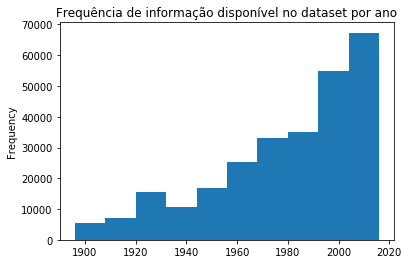

In [3]:
geral["Year"].plot.hist(title = "Frequência de informação disponível no dataset por ano")

In [4]:
sports  = pd.unique(geral["Sport"]).tolist()
versions = pd.unique(geral["Games"]).tolist()
citys = pd.unique(geral["City"]).tolist()

print("Quantidade de modalidades disponíveis no dataframe: " + str(len(sports)))
print("Quantidade de versões dos jogos olímpicos disponíveis no dataframe: " + str(len(versions)))
print("Quantidade de cidades sedes dos jogos olímpicos disponíveis no dataframe (Verão + Inverno): " + str(len(citys)))

Quantidade de modalidades disponíveis no dataframe: 66
Quantidade de versões dos jogos olímpicos disponíveis no dataframe: 51
Quantidade de cidades sedes dos jogos olímpicos disponíveis no dataframe (Verão + Inverno): 42


Média de peso dos atletas: 70.70239290053351


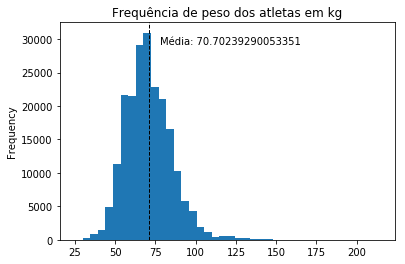

In [5]:
geral["Weight"].plot.hist(title = "Frequência de peso dos atletas em kg", bins=40)

plt.axvline(geral["Weight"].mean(), color='k', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()

plt.text(geral["Weight"].mean() + geral["Weight"].mean()/10, max_ - max_/10, 'Média: {}'.format(geral["Weight"].mean()))

print("Média de peso dos atletas: " + str(np.mean(geral["Weight"])))

É notavel assimetria nos dados em relação ao peso dos atletas. Os índices de maiores frequências estão localizados entre 50 e 80 kg aproximadamente.

Média de altura dos atletas: 175.33896987366376


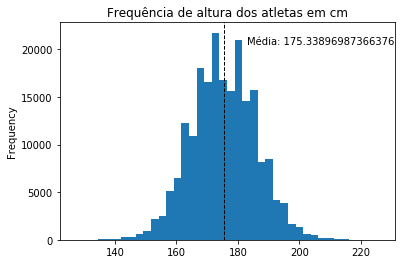

In [6]:
geral["Height"].plot.hist(title = "Frequência de altura dos atletas em cm", bins=40)

plt.axvline(geral["Height"].mean(), color='k', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()

plt.text(geral["Height"].mean() + geral["Height"].mean()/23, max_ - max_/10, 'Média: {}'.format(geral["Height"].mean()))

print("Média de altura dos atletas: " + str(np.mean(geral["Height"])))

É possível definir uma pequena simetria, de pouco valor nos dados relacionados a altura. Os índices de maiores frequências estão localizados entre 1,7 m e 1,85m aproximadamente.

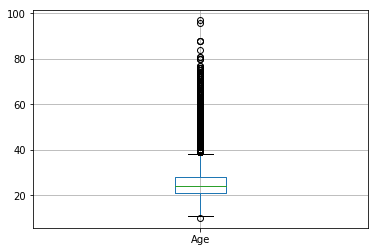

In [7]:
geral.loc[:,["Age"]].boxplot()

Média de idade dos atletas: 25.556898357297374


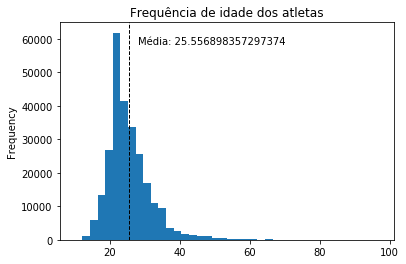

In [8]:
geral["Age"].plot.hist(title ="Frequência de idade dos atletas", bins=40)

plt.axvline(geral["Age"].mean(), color='k', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()

plt.text(geral["Age"].mean() + geral["Age"].mean()/10, max_ - max_/10, 'Média: {}'.format(geral["Age"].mean()))

print("Média de idade dos atletas: " + str(np.mean(geral["Age"])))

### 1.3 Análise da correlação entre os dados

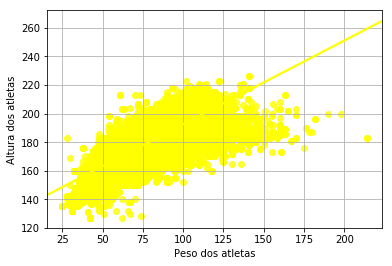

Índice de correlação (R) entre o peso e a altura dos atletas: 0.7962130921161656


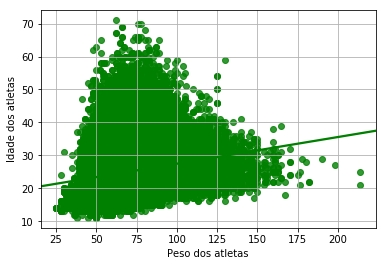

Índice de correlação (R) entre o peso e a idade dos atletas: 0.21206886474816442


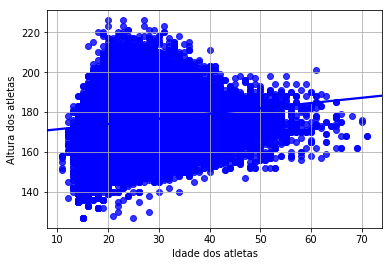

Índice de correlação (R) entre a idade a altura dos atletas: 0.13824647072838908


In [9]:
import numpy as np
import seaborn as sns

grafico1 = sns.regplot(geral['Weight'], geral['Height'], color='yellow');
plt.xlabel('Peso dos atletas')
plt.ylabel('Altura dos atletas')
plt.grid()
plt.show()
print('Índice de correlação (R) entre o peso e a altura dos atletas: '+str(geral.corr()['Weight']['Height']))

grafico2 = sns.regplot(geral['Weight'], geral['Age'], color='green');
plt.xlabel('Peso dos atletas')
plt.ylabel('Idade dos atletas')
plt.grid()
plt.show()
print('Índice de correlação (R) entre o peso e a idade dos atletas: '+str(geral.corr()['Weight']['Age']))

grafico3 = sns.regplot(geral['Age'], geral['Height'], color='blue');
plt.xlabel('Idade dos atletas')
plt.ylabel('Altura dos atletas')
plt.grid()
plt.show()
print('Índice de correlação (R) entre a idade a altura dos atletas: '+str(geral.corr()['Age']['Height']))

Entre as três análises pode-se perceber que entre peso e altura dos atletas há maior correlação. Esse índice nos indica o nível de dependência entre as variáveis e, portanto, nos mostra que essas duas variáveis são mais importantes se analisadas juntas.

### 2: Algorítimo

In [10]:
#MINIBATCHKMEANS
nclusters = 300 #len(geral["Sport"].value_counts())


geraldados = geral.loc[:,("Age", "Height", "Weight")]
geraldados2 = geraldados[geral.Season == "Summer"]
dados = geraldados2.dropna()

med = cluster.MiniBatchKMeans(n_clusters= nclusters, random_state = 0)

output = med.fit_predict(dados)
output

array([217, 295,  53, ..., 268,  71, 242])

In [11]:
#MINIBATCHKMEANS
grupos = pd.DataFrame(geral.Sport)
grupos['Grupo'] = pd.Series(output)
pd.crosstab(grupos.Sport, grupos.Grupo)
#MeanShift, DBSCAN, Spectral

Grupo,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,290.0,291.0,292.0,293.0,294.0,295.0,296.0,297.0,298.0,299.0
Sport,,,,,,,,,,,,,,,,,,,,,
Alpine Skiing,13,27,20,23,32,23,22,4,24,4,...,22,34,31,14,15,21,17,23,11,20
Alpinism,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Archery,3,4,4,2,12,4,12,3,1,2,...,1,8,8,1,1,4,2,1,4,1
Art Competitions,5,14,7,11,14,4,10,2,9,8,...,11,17,9,1,5,6,8,4,10,2
Athletics,77,115,76,86,93,75,119,51,73,58,...,88,129,123,52,72,81,71,65,65,68
Badminton,1,3,2,8,3,0,4,3,2,4,...,2,2,2,4,2,4,4,5,4,7
Baseball,0,6,2,1,3,1,1,0,0,0,...,0,4,1,0,2,3,0,4,2,0
Basketball,12,19,14,10,6,6,7,4,11,10,...,12,10,17,8,9,15,5,7,7,11
Basque Pelota,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#MeanShift
grupos = pd.DataFrame(geral.Sport)
grupos['Grupo'] = pd.Series(outputshift)
pd.crosstab(grupos.Sport, grupos.Grupo)

NameError: name 'outputshift' is not defined

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure().gca(projection="3d")
plt3d.scatter(dados.Age, dados.Weight, dados.Height)

In [ ]:
#DBSCAN 

from sklearn.cluster import DBSCAN


geral = pd.read_csv("athlete_events.csv")

nclusters = len(geral["Sport"].value_counts())
sports = pd.unique(geral["Sport"]).tolist()

geraldados = geral.loc[:,("Age", "Height", "Weight")]
geraldados2 = geraldados[geral.Season == "Summer"]
dados = geraldados2.dropna()


med = cluster.DBSCAN(eps=5)
output = med.fit_predict(dados)


a = pd.Series(output)
a.value_counts()

grupos = pd.DataFrame(geral.Sport)
grupos['Grupo'] = pd.Series(output)
pd.crosstab(grupos.Sport, grupos.Grupo)

In [15]:
geral7 = pd.concat([geral[geral.Sport=="Basketball"], geral[geral.Sport=="Wrestling"], geral[geral.Sport=="Swimming"], 
           geral[geral.Sport=="Shooting"], geral[geral.Sport=="Athletics"], geral[geral.Sport=="Gymnastics"],
          geral[geral.Sport=="Equestrianism"]])
geral7

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
167,69,Tamara Abalde Daz,F,19.0,185.0,72.0,Spain,ESP,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Women's Basketball,NaN
250,124,Youssef Mohamed Abbas,M,31.0,NaN,NaN,Egypt,EGY,1952 Summer,1952,Summer,Helsinki,Basketball,Basketball Men's Basketball,NaN
264,136,Alessandro Abbio,M,29.0,195.0,85.0,Italy,ITA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,NaN
346,192,Ahmed El-Sayed Abdel Hamid Mobarak,M,25.0,189.0,85.0,Egypt,EGY,1972 Summer,1972,Summer,Munich,Basketball,Basketball Men's Basketball,NaN
359,199,Amir Abdel Meguid,M,23.0,178.0,67.0,Egypt,EGY,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Men's Basketball,NaN
360,199,Amir Abdel Meguid,M,27.0,178.0,67.0,Egypt,EGY,1988 Summer,1988,Summer,Seoul,Basketball,Basketball Men's Basketball,NaN
363,202,Awad Abdel Nabi Awad,M,19.0,198.0,80.0,Egypt,EGY,1972 Summer,1972,Summer,Munich,Basketball,Basketball Men's Basketball,NaN
364,202,Awad Abdel Nabi Awad,M,23.0,198.0,80.0,Egypt,EGY,1976 Summer,1976,Summer,Montreal,Basketball,Basketball Men's Basketball,NaN
490,270,Alaa El-Din Abdoun,M,23.0,188.0,78.0,Egypt,EGY,1988 Summer,1988,Summer,Seoul,Basketball,Basketball Men's Basketball,NaN


In [17]:
from sklearn.model_selection import train_test_split
X=(geral7)
X_train, X_test = train_test_split(X, test_size=0.2)
X_train

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
156092,78385,Jarl Inge Melberg,M,22.0,196.0,84.0,Norway,NOR,1992 Summer,1992,Summer,Barcelona,Swimming,Swimming Men's 400 metres Freestyle,NaN
250797,125618,Aneliya Dulcheva Vechernikova-Nuneva,F,26.0,167.0,57.0,Bulgaria,BUL,1988 Summer,1988,Summer,Seoul,Athletics,Athletics Women's 100 metres,NaN
91131,46193,Alvin Leonardo Harrison,M,22.0,188.0,80.0,United States,USA,1996 Summer,1996,Summer,Atlanta,Athletics,Athletics Men's 4 x 400 metres Relay,Gold
195175,97968,Rebeca Lissette Quinteros Ortz,F,18.0,NaN,NaN,El Salvador,ESA,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 400 metres Freestyle,NaN
99115,50157,Shigeyuki Hosono,M,31.0,180.0,70.0,Japan,JPN,2000 Summer,2000,Summer,Sydney,Equestrianism,"Equestrianism Mixed Three-Day Event, Team",NaN
173894,87354,"Glynis Leanne Nunn (Saunders-, -Cearns)",F,23.0,168.0,58.0,Australia,AUS,1984 Summer,1984,Summer,Los Angeles,Athletics,Athletics Women's 100 metres Hurdles,NaN
100119,50659,Huang Xu,M,21.0,162.0,59.0,China,CHN,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Men's Pommelled Horse,NaN
169532,85233,Martina Nemec,F,20.0,171.0,62.0,Austria,AUT,1996 Summer,1996,Summer,Atlanta,Swimming,Swimming Women's 400 metres Individual Medley,NaN
191620,96203,Veronika Andreyevna Popova,F,21.0,182.0,68.0,Russia,RUS,2012 Summer,2012,Summer,London,Swimming,Swimming Women's 4 x 100 metres Freestyle Relay,NaN
233613,117166,Franz Swoboda,M,27.0,NaN,NaN,Austria,AUT,1936 Summer,1936,Summer,Berlin,Gymnastics,Gymnastics Men's Team All-Around,NaN
